# MCOE of US Coal Plants based on FERC Form 1
This notebook is meant to generate some plots and statistics to demonstrate the fact that our database can access and explore the non-fuel expenses of coal fired power plants in the US.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
pudl_engine = pudl.connect_db()
plt.style.use('ggplot')
mpl.rc('figure', figsize=(10,6))
mpl.rc('figure', dpi=100)
mpl.rc('animation', writer='ffmpeg')

In [2]:
# First, identify all the FERC Coal plants, based on their fuel consumption patterns...
fuel_df = analysis.get_fuel_ferc1_df()
steam_df = analysis.get_steam_ferc1_df()
fuel_ferc1_proportions = analysis.plant_fuel_proportions_ferc1(fuel_df)
fuel_ferc1_proportions = fuel_ferc1_proportions.merge(analysis.primary_fuel_ferc1(fuel_df, fuel_thresh=0.5),
                                                      on=['report_year','respondent_id','plant_name'])
steam_fuel_df = steam_df.merge(fuel_ferc1_proportions,
                               on=['report_year','respondent_id','plant_name'])

In [3]:
def plot_fossil_mcoe(steam_fuel_df,
                     alpha=0.6,
                     normed=False,
                     weights='net_generation_mwh',
                     range=(10,130),
                     bins=60,
                     cumulative=False,
                     title='',
                     ymax=None,
                     wind=25):
    """Plot distribution of MCOE for coal and gas plants from FERC data."""
    coal_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='coal']
    plt.hist(coal_plants['expns_per_mwh'],
             weights=coal_plants[weights],
             bins=bins, range=range, alpha=alpha, normed=normed,
             label='Coal', cumulative=cumulative)
    
    gas_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='gas']
    plt.hist(gas_plants['expns_per_mwh'],
             weights=gas_plants[weights],
             bins=bins, range=range, alpha=alpha, normed=normed,
             label='Natural gas', cumulative=cumulative)
    
    plt.xlabel('$ / MWh')
    if cumulative:
        plt.ylabel('Proportion of Net generation (MWh)')
    else:
        plt.ylabel('Net generation (MWh)')
        
    if ymax is not None:
        ymin=0
        plt.ylim(ymin, ymax)
    else:
        ymin, ymax = plt.ylim()
    plt.title('US Fossil Plant MCOE (FERC Form 1, {})'.format(title))
    if(wind!=0):
        plt.vlines(wind, ymin, ymax*1.05)
        plt.ylim(ymin, ymax)
        plt.text(wind-2.0, ymax*0.9, 'Wind PPA: ${}/MWh'.format(wind), rotation=90)
    plt.legend();

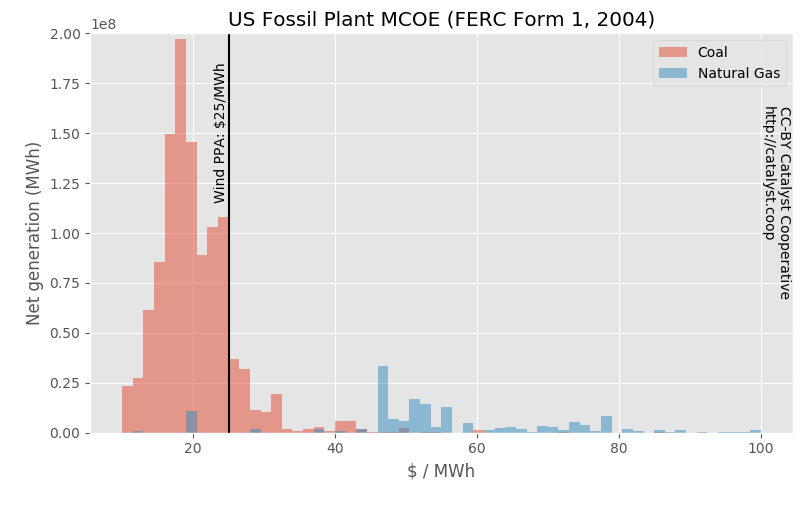

In [23]:
# animation function. This is called sequentially
def mcoe_animate(yr, steam_fuel_df):
    alpha=0.5
    weights='net_generation_mwh'
    mcoe_range=(10,100)
    ymax=2e8
    bins=60
    normed=False
    cumulative=False
    title=yr
    wind=25
    
    plt.cla()
    
    coal_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='coal']
    coal_plants = coal_plants[coal_plants['report_year']==yr]
    
    plt.hist(coal_plants['expns_per_mwh'],
             weights=coal_plants[weights],
             bins=bins, range=mcoe_range, alpha=alpha, normed=normed,
             label='Coal', cumulative=cumulative)
    
    gas_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='gas']
    gas_plants = gas_plants[gas_plants['report_year']==yr]
    plt.hist(gas_plants['expns_per_mwh'],
             weights=gas_plants[weights],
             bins=bins, range=mcoe_range, alpha=alpha, normed=normed,
             label='Natural Gas', cumulative=cumulative)
    
    plt.xlabel('$ / MWh')
    if cumulative:
        plt.ylabel('Proportion of Net generation (MWh)')
    else:
        plt.ylabel('Net generation (MWh)')
        
    if ymax is not None:
        ymin=0
        plt.ylim(ymin, ymax)
    else:
        ymin, ymax = plt.ylim()
    plt.title('US Fossil Plant MCOE (FERC Form 1, {})'.format(title))
    if(wind!=0):
        plt.vlines(wind, ymin, ymax*1.05)
        plt.ylim(ymin, ymax)
        plt.text(wind-2.0, ymax*0.9, 'Wind PPA: ${}/MWh'.format(wind), rotation=90)
    plt.legend()
    plt.text(100,1.5e8,'''CC-BY Catalyst Cooperative
http://catalyst.coop''', rotation=270)
    plt.tight_layout()
    
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)
years = [2004, 2004, 2004]+list(range(2004,2017))+[2016, 2016, 2016]
anim = animation.FuncAnimation(fig,
                               mcoe_animate,
                               frames=years,
                               fargs=(steam_fuel_df,),
                               interval=1000,
                               repeat=True,
                               repeat_delay=2000)
anim.save('fossil_mcoe.gif', dpi=100, writer='imagemagick')
HTML(anim.to_html5_video())

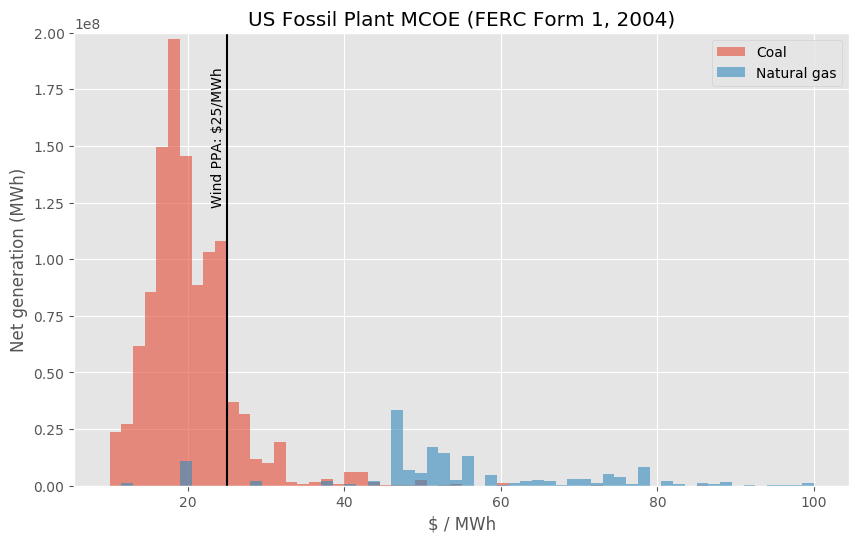

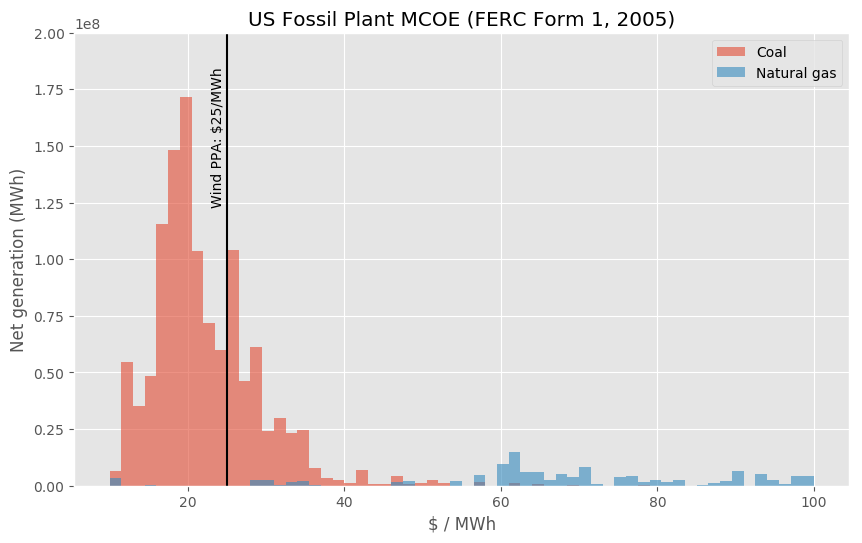

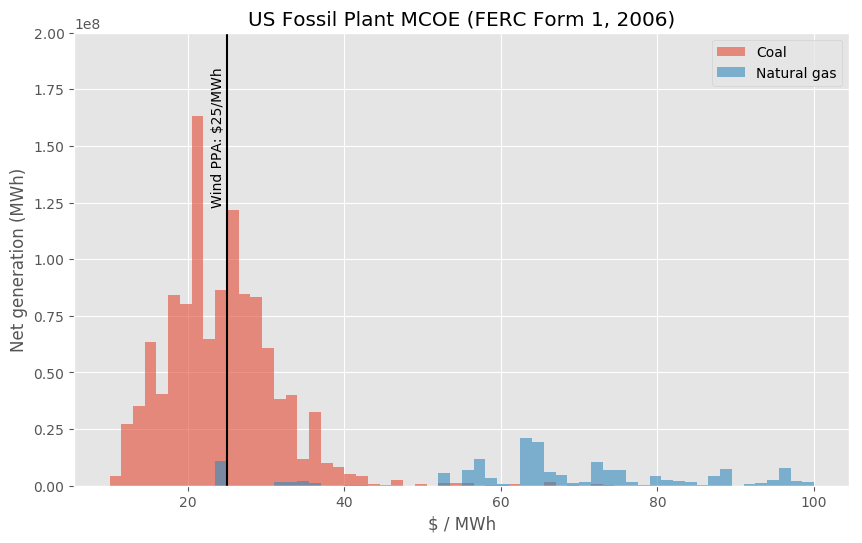

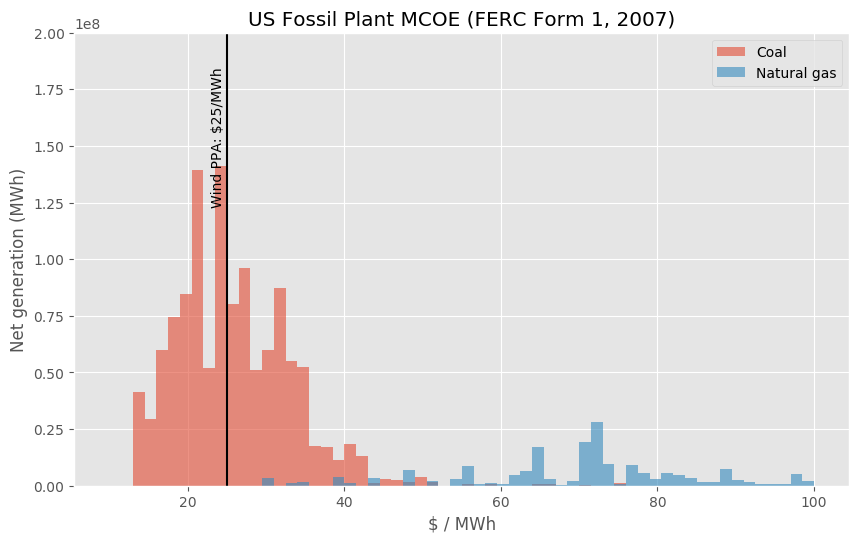

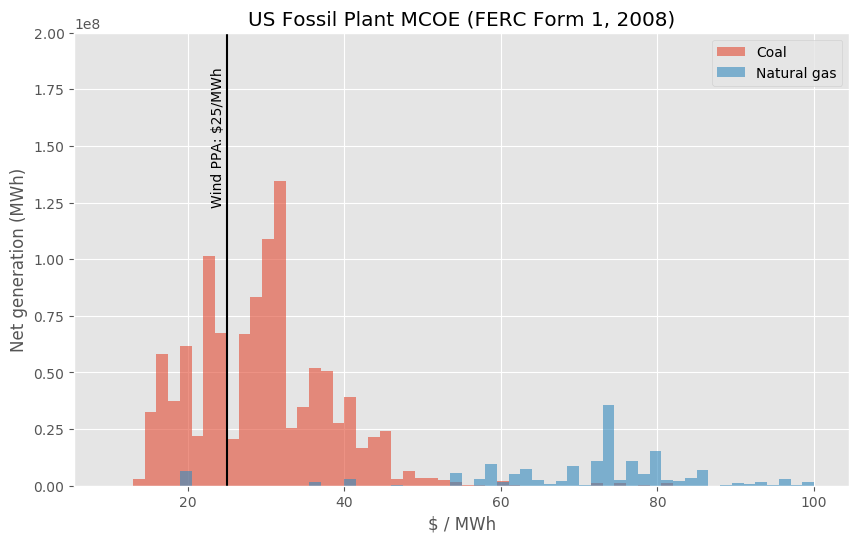

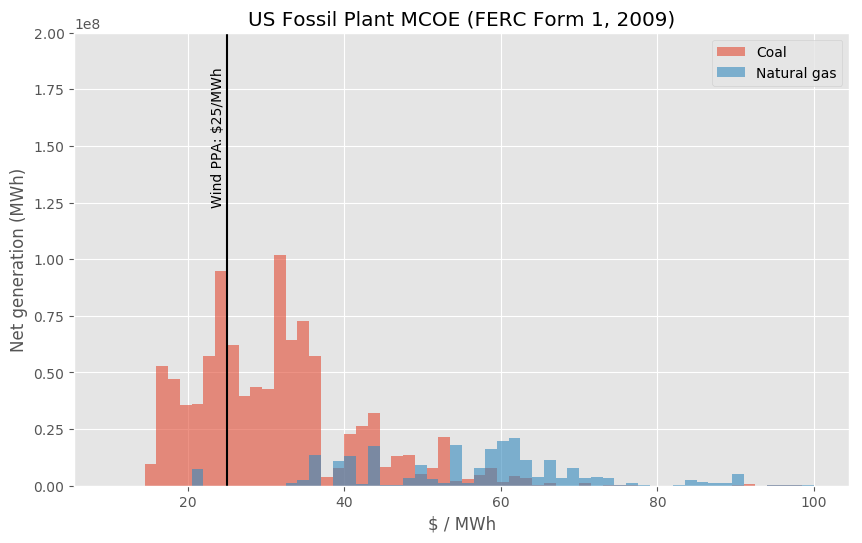

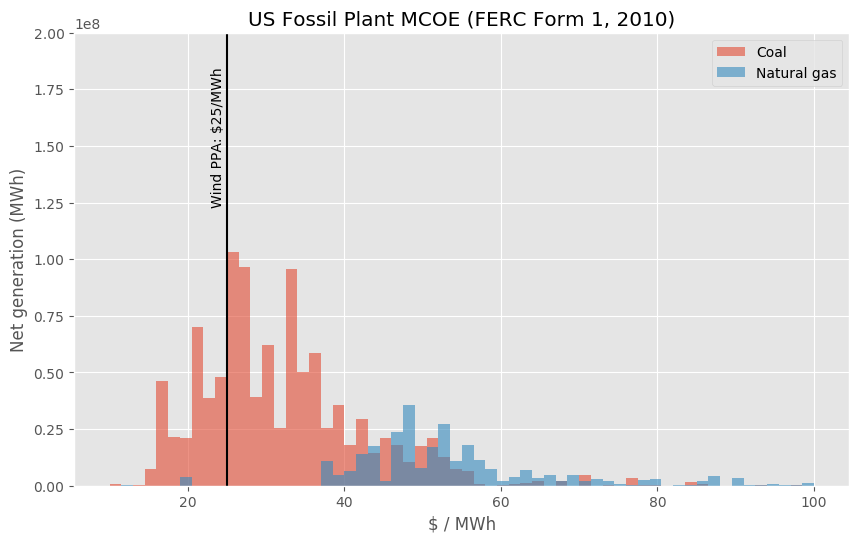

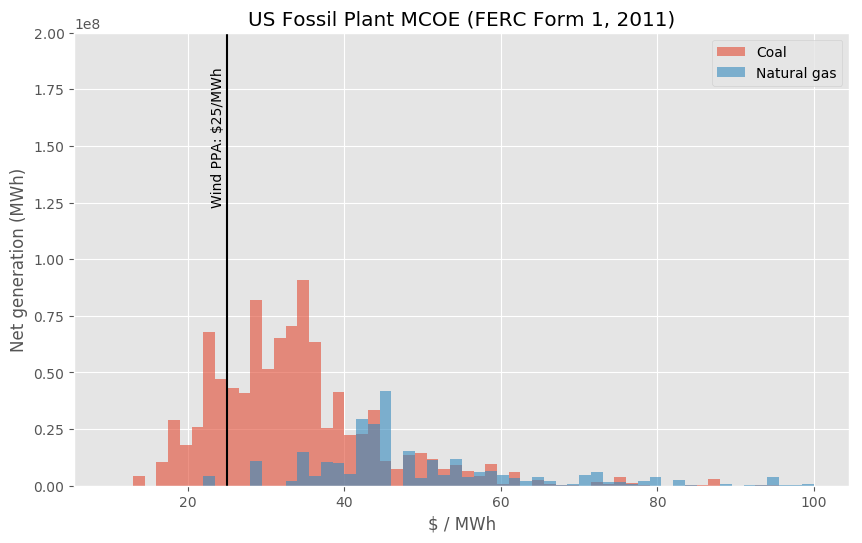

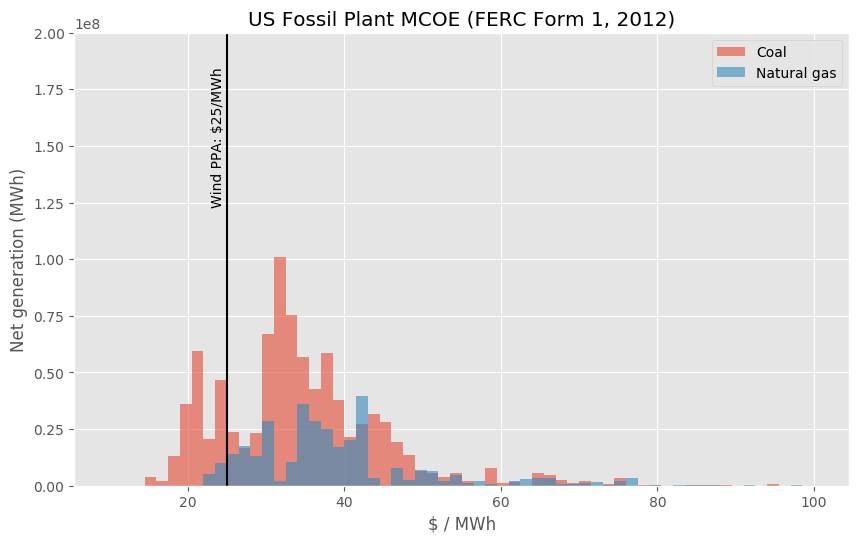

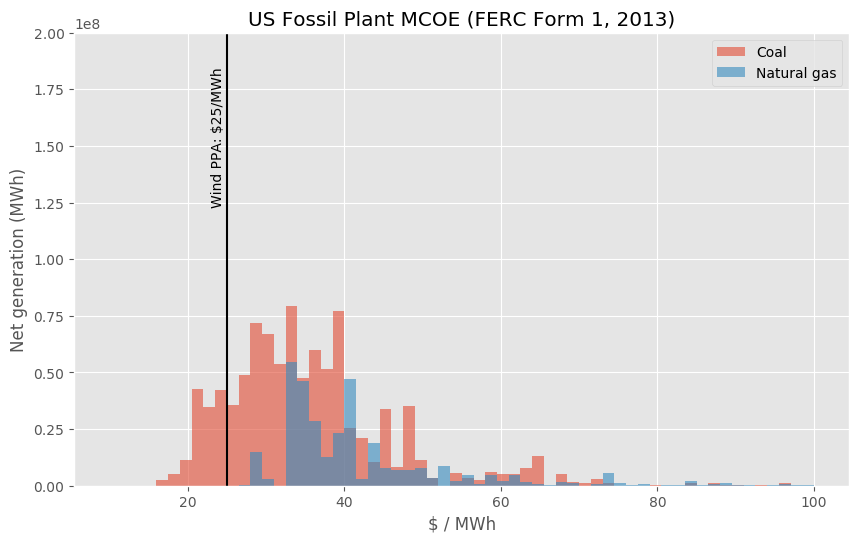

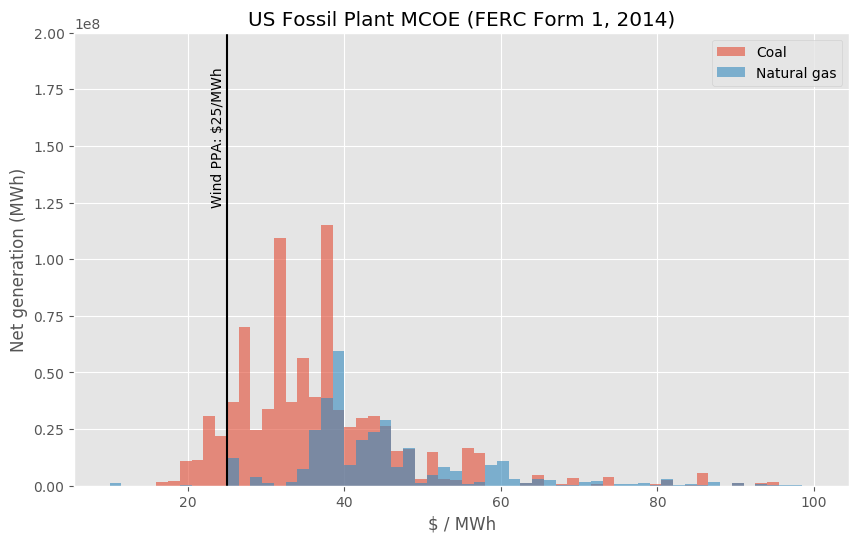

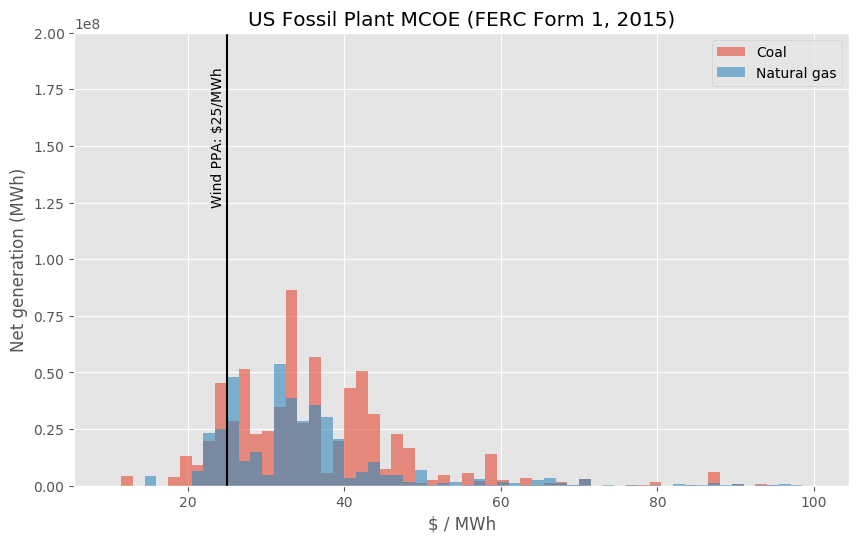

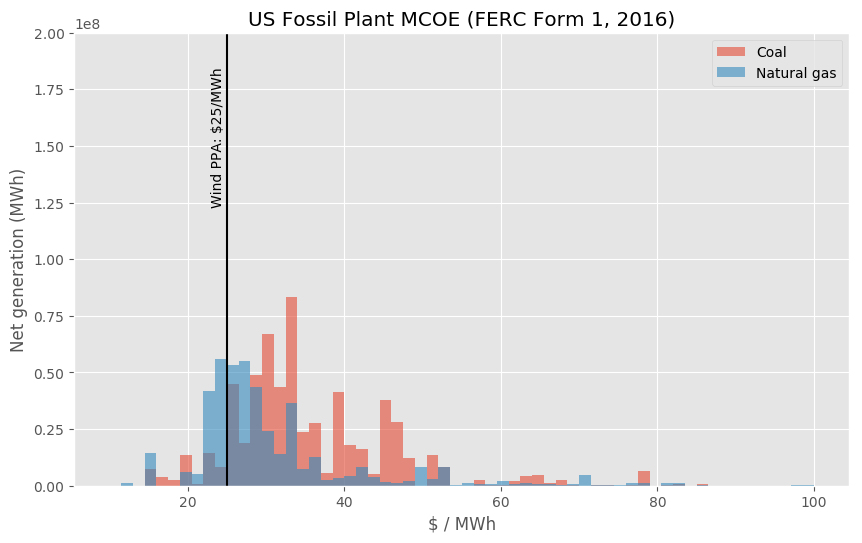

In [5]:
for year in constants.ferc1_working_years:
    plot_fossil_mcoe(steam_fuel_df[steam_fuel_df['report_year']==year],
                     title=year,
                     bins=60,
                     wind=25,
                     range=(10,100),
                     ymax=2e8,
                     normed=False)
    #fig.savefig('ferc1_coal_gas_mcoe_{}.png'.format(year))
    plt.show()